In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re, json
from collections import defaultdict

## Carga de datos

### Twitter

In [2]:
twitter_path = 'Data/Twitter/Twitter_Data.csv'
twitter_data = pd.read_csv(twitter_path)
twitter_data

/var/folders/2h/91q4sd4x3t13f8n_dy5nkj_00000gn/T/ipykernel_3359/2898866676.py:2: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  twitter_data = pd.read_csv(twitter_path)


,n_replies,text,text_clean,text_lemma,Topic_label,id,body_words,all_body_words,Distinctly.Emotoinal,Distinctly.Moral,...,party,ACount_unq,MCount_unq,shared,posCount_unq,shared_pos,negCount_unq,shared_neg,channel,day
0,1388,"Over 1,100,000 people killed by guns in the US...",people killed guns usa since @johnlennon shot ...,people kill gun usa since @johnlennon shoot ki...,Gun Control,1.0,11,20,0,0,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,Twitter,2015-12-01
1,762,"Over 1,100,000 people killed by guns in the US...",people killed guns usa since @johnlennon shot ...,people kill gun usa since @johnlennon shoot ki...,Gun Control,2.0,11,20,0,0,...,NaN,0.0,0.0,2.0,0.0,0.0,0.0,2.0,Twitter,2015-12-01
2,748,If liberals won't punish an entire religion fo...,liberals punish entire religion actions insist...,liberal punish entire religion action insist p...,Gun Control,3.0,9,23,0,1,...,1.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,Twitter,2015-12-01
3,436,"""@JenniferJJacobs: Trump: ""Protect the 2nd ame...",@jenniferjjacobs trump protect 2nd amendment w...,@jenniferjjacobs trump protect 2nd amendment w...,Gun Control,4.0,10,17,1,1,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,Twitter,2015-12-01
4,342,Kurt Russell put gun control activists on blas...,kurt russell put gun control activists blast r...,kurt russell put gun control activist blast re...,Gun Control,5.0,9,14,0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Twitter,2015-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986680,2809,On the International Day Against Homophobia an...,international day homophobia transphobia recom...,international day homophobia transphobia recom...,Clinton_feed,10673679.0,11,19,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Twitter,5/17/2016
986681,2079,Today<U+2019>s #RNCinCLE theme: <U+201C>Law an...,today' #rncincle theme law order,today' #rncincle theme law order,Clinton_feed,10673680.0,5,6,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Twitter,7/18/2016
986682,600,We've come too far to let Republicans take us ...,come far let republicans take us back commit v...,come far let republican take us back commit vo...,Clinton_feed,10673681.0,11,19,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Twitter,1/27/2016
986683,1712,Trump says he hires the best people. This is w...,trump says hires best people means,trump say hire good people mean,Clinton_feed,10673682.0,6,13,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Twitter,8/20/2016


In [3]:
twitter_data.columns

Index(['n_replies', 'text', 'text_clean', 'text_lemma', 'Topic_label', 'id',
       'body_words', 'all_body_words', 'Distinctly.Emotoinal',
       'Distinctly.Moral', 'emo_neg', 'emo_pos', 'Moral.emotional', 'Neutral',
       'authority.vice', 'authority.virtue', 'care.vice', 'care.virtue',
       'fairness.vice', 'fairness.virtue', 'loyalty.vice', 'loyalty.virtue',
       'moral_all', 'MoralityGeneral', 'sanctity.vice', 'sanctity.virtue',
       'vice', 'virtue', 'Distinctly.Emotoinal.y', 'Distinctly.Moral.y',
       'emo_neg.y', 'emo_pos.y', 'Moral.emotional.y', 'Neutral.y',
       'authority.vice.y', 'authority.virtue.y', 'care.vice.y',
       'care.virtue.y', 'fairness.vice.y', 'fairness.virtue.y',
       'loyalty.vice.y', 'loyalty.virtue.y', 'moral_all.y',
       'MoralityGeneral.y', 'sanctity.vice.y', 'sanctity.virtue.y', 'vice.y',
       'virtue.y', 'user.verified', 'url', 'media', 'followers', 'topic',
       'src_id', 'ideology', 'hasIdeo', 'party_mean', 'party', 'ACount_unq',

In [4]:
twitter_data["text"][0]

'Over 1,100,000 people killed by guns in the USA since @JohnLennon was shot and killed on Dec 8 1980\r\n#StopGunViolence https://t<U+2026>'

In [4]:
twitter_data["text_clean"][0]

'people killed guns usa since @johnlennon shot killed dec #stopgunviolence https'

In [5]:
twitter_data["text_lemma"][0]

'people kill gun usa since @johnlennon shoot kill dec #stopgunviolence https'

In [6]:
twitter_data[["n_replies"]].describe()

,n_replies
count,986685.000000
mean,1087.989355
std,3242.786507
min,0.000000
25%,0.000000
50%,2.000000
75%,298.000000
max,543692.000000


topicos en twitter

In [7]:
twitter_data["Topic_label"].unique()

array(['Gun Control', 'Same-sex Marriage', 'Climate Change',
       'Trump elections', 'Women March', 'Post Brexit', 'Mueller Report',
       'MeToo', 'Trump_feed', 'Clinton_feed'], dtype=object)

In [9]:
twitter_data["Topic_label"].value_counts()

Topic_label
MeToo                393135
Climate Change       235548
Mueller Report       229046
Gun Control           48394
Same-sex Marriage     29058
Post Brexit           17998
Women March           15000
Trump elections        9001
Trump_feed             4794
Clinton_feed           4711
Name: count, dtype: int64

## Moral Foundations Dictionary

cargar wmodel y parsearlo a un formato json legible

In [10]:
lines = Path("moral_foundations_dictionary/Moral Foundations Dictionary.wmodel").read_text(encoding="utf-8", errors="ignore").splitlines()

# Encabezados como "CARE.VIRTUE" o "SANCTITY.VICE"
cat_re  = re.compile(r'^\s*([A-Z]+)\.(VIRTUE|VICE)\s*$')
# Términos como "ALTRUISM (1)" (ignora comentarios/otros)
term_re = re.compile(r'^\s*([^\s#;].*?)\s*\(\d+\)\s*$')

mfd = defaultdict(lambda: {"virtue": [], "vice": []})
current = None  # (foundation, valence)

for line in lines:
    m = cat_re.match(line)
    if m:
        foundation = m.group(1).lower()   # care, fairness, ...
        valence    = m.group(2).lower()   # virtue / vice
        current = (foundation, valence)
        continue

    if current:
        t = term_re.match(line)
        if t:
            term = t.group(1).strip()
            mfd[current[0]][current[1]].append(term)

with open("mfd_canonical.json", "w", encoding="utf-8") as f:
    json.dump(mfd, f, ensure_ascii=False, indent=2)


### lista total de palabras morales

In [3]:
with open("moral_foundations_dictionary/mfd_canonical.json", encoding="utf-8") as f:
    mfd = json.load(f)

# Lista completa de palabras (todas las categorías y valencias)
moral_words = sorted({t for v in mfd.values() for terms in v.values() for t in terms})


In [5]:
moral_words

['ABHOR',
 'ABHORRED',
 'ABHORS',
 'ABSTINANCE',
 'ABSTINENCE',
 'ABUSED',
 'ABUSER',
 'ABUSERS',
 'ABUSES',
 'ABUSING',
 'ACHE',
 'ACHED',
 'ACHES',
 'ACHING',
 'ACHINGLY',
 'ACQUIESCE',
 'ACQUIESCED',
 'ACQUIESCENT',
 'ACQUIESCES',
 'ACQUIESCING',
 'ADDICT',
 'ADDICTED',
 'ADDICTING',
 'ADDICTION',
 'ADDICTIONS',
 'ADDICTS',
 'ADHERE',
 'ADHERED',
 'ADHERENCE',
 'ADHERES',
 'ADHERING',
 'ADMIRAL',
 'ADMIRALS',
 'ADULTERER',
 'ADULTERERS',
 'ADULTEROUS',
 'ADULTERY',
 'AFFLICT',
 'AFFLICTED',
 'AFFLICTION',
 'AFFLICTIONS',
 'AFFLICTS',
 'AGAINST_US',
 'AGONIZE',
 'AGONIZED',
 'AGONIZING',
 'AGONIZINGLY',
 'AGONY',
 'ALCOHOLIC',
 'ALCOHOLICS',
 'ALCOHOLISM',
 'ALLAH',
 'ALLEGIANCE',
 'ALLEGIANCES',
 'ALLEGIANT',
 'ALLEVIATE',
 'ALLEVIATED',
 'ALLEVIATES',
 'ALLEVIATING',
 'ALLEVIATION',
 'ALLIED',
 'ALLIES',
 'ALLY',
 'ALL_FOR_ONE',
 'ALMIGHTY',
 'ALTRUISM',
 'ALTRUIST',
 'AM_PARTIAL',
 'ANARCHIST',
 'ANARCHISTIC',
 'ANARCHISTS',
 'ANARCHY',
 'ANGEL',
 'ANGUISH',
 'ANGUISHED',
 'ANGUIS

In [8]:
"HELLO" in moral_words

False

In [9]:
"SHOULD" in moral_words

False

In [21]:
"MUST" in moral_words

False

In [10]:
"PRESIDENT" in moral_words

True

In [11]:
"HEALTH" in moral_words

True

In [12]:
"INTEGRITY" in moral_words

True

In [13]:
len(moral_words)

2041

In [12]:
import nltk
def ensure_nltk_data():
    # WordNet (lematizador)
    try:
        nltk.data.find('corpora/wordnet')
    except LookupError:
        nltk.download('wordnet')
    try:
        nltk.data.find('corpora/omw-1.4')
    except LookupError:
        nltk.download('omw-1.4')

    # POS tagger (nombre nuevo en 3.8+, y antiguo por compat.)
    try:
        nltk.data.find('taggers/averaged_perceptron_tagger_eng')
    except LookupError:
        try:
            nltk.download('averaged_perceptron_tagger_eng')
        except Exception:
            # fallback a la versión anterior
            try:
                nltk.data.find('taggers/averaged_perceptron_tagger')
            except LookupError:
                nltk.download('averaged_perceptron_tagger')

ensure_nltk_data()


[nltk_data] Error loading wordnet: HTTP Error 429: Too Many Requests
[nltk_data] Error loading omw-1.4: HTTP Error 429: Too Many Requests


incluir lemas dentro del diccionario

In [4]:

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

lemmatizer = WordNetLemmatizer()

def _wn_pos(tag: str):
    if tag.startswith('J'): return wordnet.ADJ
    if tag.startswith('V'): return wordnet.VERB
    if tag.startswith('N'): return wordnet.NOUN
    if tag.startswith('R'): return wordnet.ADV
    return wordnet.NOUN  # por defecto

def lemmatize_token_list_nltk(tokens, *, min_len=2, drop_numeric=True):
    """Lematiza una lista de tokens en inglés usando POS tags."""
    # filtros opcionales
    toks = [t.lower() for t in tokens
            if (len(t) >= min_len) and (not (drop_numeric and t.isnumeric()))]
    # POS tagging y lematización
    pos = nltk.pos_tag(toks)
    return [lemmatizer.lemmatize(w, _wn_pos(p)).upper() for w, p in pos]

moral_words = np.unique(moral_words + lemmatize_token_list_nltk(moral_words))

In [23]:
"ABUSE" in moral_words

True

### por categorías

In [14]:
# 1) Diccionario por FOUNDATION (unifica virtue y vice)
by_foundation = {
    foundation: sorted({t for terms in valences.values() for t in terms})
    for foundation, valences in mfd.items()
}

# 2) Diccionario por PAIR (foundation.valence)
by_pairs = {
    f"{foundation}.{valence}": sorted(set(terms))
    for foundation, valences in mfd.items()
    for valence, terms in valences.items()
}

# (Opcional) Controles rápidos
print("FOUNDATIONS:", {k: len(v) for k, v in by_foundation.items()})
print("PAIRS:", {k: len(v) for k, v in by_pairs.items()})

FOUNDATIONS: {'care': 464, 'fairness': 351, 'loyalty': 192, 'authority': 431, 'sanctity': 660}
PAIRS: {'care.virtue': 182, 'care.vice': 288, 'fairness.virtue': 115, 'fairness.vice': 236, 'loyalty.virtue': 143, 'loyalty.vice': 49, 'authority.virtue': 301, 'authority.vice': 130, 'sanctity.virtue': 272, 'sanctity.vice': 388}


In [15]:
sum([len(v) for _, v in by_foundation.items()])

2098

In [16]:
foundations_total_list = []
for word_list in [list(v) for _, v in by_foundation.items()]:
    foundations_total_list += word_list



In [17]:
len(np.unique(foundations_total_list))

2041

### Conteo de palabras morales

In [18]:
twitter_data

,n_replies,text,text_clean,text_lemma,Topic_label,id,body_words,all_body_words,Distinctly.Emotoinal,Distinctly.Moral,...,party,ACount_unq,MCount_unq,shared,posCount_unq,shared_pos,negCount_unq,shared_neg,channel,day
0,1388,"Over 1,100,000 people killed by guns in the US...",people killed guns usa since @johnlennon shot ...,people kill gun usa since @johnlennon shoot ki...,Gun Control,1.0,11,20,0,0,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,Twitter,2015-12-01
1,762,"Over 1,100,000 people killed by guns in the US...",people killed guns usa since @johnlennon shot ...,people kill gun usa since @johnlennon shoot ki...,Gun Control,2.0,11,20,0,0,...,NaN,0.0,0.0,2.0,0.0,0.0,0.0,2.0,Twitter,2015-12-01
2,748,If liberals won't punish an entire religion fo...,liberals punish entire religion actions insist...,liberal punish entire religion action insist p...,Gun Control,3.0,9,23,0,1,...,1.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,Twitter,2015-12-01
3,436,"""@JenniferJJacobs: Trump: ""Protect the 2nd ame...",@jenniferjjacobs trump protect 2nd amendment w...,@jenniferjjacobs trump protect 2nd amendment w...,Gun Control,4.0,10,17,1,1,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,Twitter,2015-12-01
4,342,Kurt Russell put gun control activists on blas...,kurt russell put gun control activists blast r...,kurt russell put gun control activist blast re...,Gun Control,5.0,9,14,0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Twitter,2015-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986680,2809,On the International Day Against Homophobia an...,international day homophobia transphobia recom...,international day homophobia transphobia recom...,Clinton_feed,10673679.0,11,19,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Twitter,5/17/2016
986681,2079,Today<U+2019>s #RNCinCLE theme: <U+201C>Law an...,today' #rncincle theme law order,today' #rncincle theme law order,Clinton_feed,10673680.0,5,6,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Twitter,7/18/2016
986682,600,We've come too far to let Republicans take us ...,come far let republicans take us back commit v...,come far let republican take us back commit vo...,Clinton_feed,10673681.0,11,19,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Twitter,1/27/2016
986683,1712,Trump says he hires the best people. This is w...,trump says hires best people means,trump say hire good people mean,Clinton_feed,10673682.0,6,13,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Twitter,8/20/2016


In [5]:
def moral_counter(tokens, moral_words):
    """
    Conteo de palabras morales
    """
    return sum([1 if token in moral_words else 0 for token in tokens])

In [6]:
import nltk
from nltk import bigrams
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

In [15]:
twitter_data["text"].astype(str).values

array(['Over 1,100,000 people killed by guns in the USA since @JohnLennon was shot and killed on Dec 8 1980\r\n#StopGunViolence https://t<U+2026>',
       'Over 1,100,000 people killed by guns in the USA since @JohnLennon was shot and killed on Dec 8 1980\r\n#StopGunViolence https:<U+2026>',
       'If liberals won\'t punish an entire religion for "the actions of a few," why do they insist on punishing all gun owners <U+2026>',
       ...,
       "We've come too far to let Republicans take us back. Commit to vote or caucus for Hillary. https://t.co/Y4YpLTep2Z https://t.co/qfLXZEieYJ",
       'Trump says he hires the best people. This is what he means: https://t.co/FvCVcmLLCY',
       "Helping small businesses succeed is about more than policy<U+2014>it's personal. https://t.co/mHmnin9sOR https://t.co/x0HTkkomBQ"],
      shape=(986685,), dtype=object)

## Word Embeddings

In [9]:
from gensim.models import KeyedVectors

# gensim puede leer .bin.gz directo; usa mmap='r' para no cargar todo a RAM de golpe
path_embedding = "word_embeddings/GoogleNews-vectors-negative300.bin.gz"
kv = KeyedVectors.load_word2vec_format(path_embedding, binary=True)


In [7]:
def get_representation_vector(kv, words, fill="zeros"):
    """fill: 'zeros' => devuelve vector 0 si no hay tokens válidos
             'nan'   => devuelve NaN (evítalo si usarás sklearn)
             'none'  => devuelve None y lo saltas afuera
    """
    vecs = [kv.get_vector(w.lower())
            for w in words
            if '_' not in w and kv.has_index_for(w.lower())]
    if not vecs:
        if fill == "zeros":
            return np.zeros(kv.vector_size, dtype=np.float32)
        if fill == "nan":
            return np.full(kv.vector_size, np.nan, dtype=np.float32)
        if fill == "none":
            return None
    M = np.vstack(vecs)
    return M.mean(axis=0)

In [10]:
from sklearn.metrics.pairwise import cosine_similarity 

moral_words_vector = get_representation_vector(kv, moral_words)

## Análisis twitter

In [11]:
docs_twitter = twitter_data["text"].astype(str).values

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs_twitter)):
    docs_twitter[idx] = docs_twitter[idx].upper()  # Convert to lowercase.
    docs_twitter[idx] = tokenizer.tokenize(docs_twitter[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs_twitter = [[token for token in doc if not token.isnumeric()] for doc in docs_twitter]

# Remove words that are only one character.
docs_twitter = [[token for token in doc if len(token) > 1] for doc in docs_twitter]

In [19]:
docs_twitter[0]

['OVER',
 'PEOPLE',
 'KILLED',
 'BY',
 'GUNS',
 'IN',
 'THE',
 'USA',
 'SINCE',
 'JOHNLENNON',
 'WAS',
 'SHOT',
 'AND',
 'KILLED',
 'ON',
 'DEC',
 'STOPGUNVIOLENCE',
 'HTTPS']

In [12]:
twitter_data["message_len"] = [len(doc) for doc in docs_twitter]
twitter_data["moral_loading"] = [moral_counter(doc, moral_words) for doc in docs_twitter]
twitter_data["moral_ratio"] = twitter_data["moral_loading"] / twitter_data["message_len"]

In [13]:
twitter_data[twitter_data["text"].str.contains("sexual abuse is wrong", case=False, na=False, regex=False)]

,n_replies,text,text_clean,text_lemma,Topic_label,id,body_words,all_body_words,Distinctly.Emotoinal,Distinctly.Moral,...,shared,posCount_unq,shared_pos,negCount_unq,shared_neg,channel,day,message_len,moral_loading,moral_ratio
668709,0,Honorable men don't have to have a daughter to...,honorable men daughter know sexual abuse wrong...,honorable man daughter know sexual abuse wrong...,MeToo,10355708.0,10,22,1,0,...,NaN,NaN,NaN,NaN,NaN,Twitter,42928.939583,25,3,0.120000
738290,14,As long as we keep acting like sexual abuse is...,long keep acting like sexual abuse wrong abuse...,long keep act like sexual abuse wrong abuser p...,MeToo,10425289.0,12,21,2,0,...,NaN,NaN,NaN,NaN,NaN,Twitter,43051.981944,26,3,0.115385
738671,14,"""If we keep acting like sexual abuse is wrong ...",keep acting like sexual abuse wrong abuser phy...,keep act like sexual abuse wrong abuser physic...,MeToo,10425670.0,12,19,3,0,...,NaN,NaN,NaN,NaN,NaN,Twitter,43051.973611,24,4,0.166667


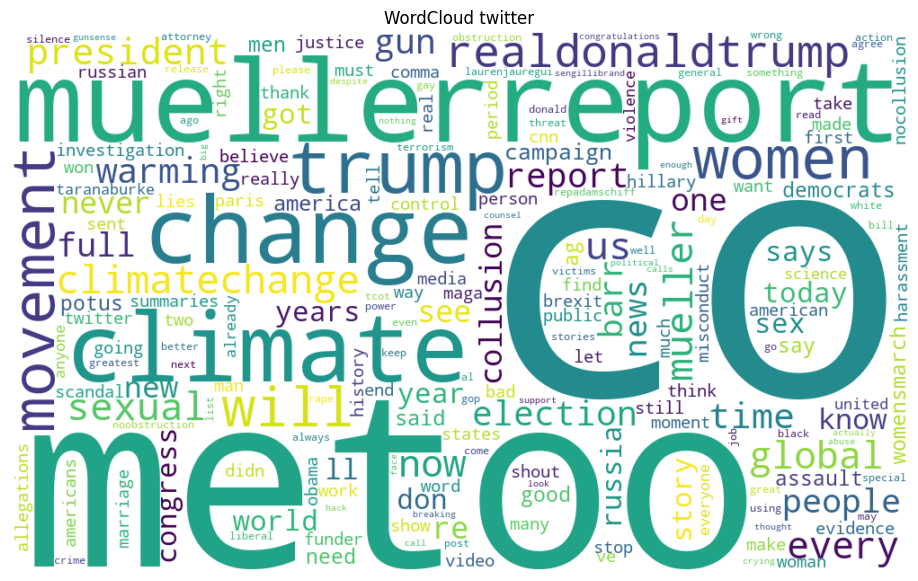

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter

min_len = 2                # longitud mínima de token
solo_alfabetico = True     # descartar tokens con números/símbolos
extra_stopwords = {
    # añade las tuyas; ejemplo en español:
    "https", "http", "rt", "via", "q", "amp"
}
stopwords = set(STOPWORDS) | extra_stopwords

# --- Aplanar y filtrar ---
tokens = [tok for tw in docs_twitter for tok in tw]
if solo_alfabetico:
    tokens = [t for t in tokens if t.isalpha()]
tokens = [t.lower() for t in tokens if len(t) >= min_len and t.lower() not in stopwords]

freqs = Counter(tokens)  # {'hola': 3, 'mundo': 2, ...}

wc_freq = WordCloud(
    width=1000, height=600,
    background_color="white"
).generate_from_frequencies(freqs)

plt.figure(figsize=(12,7))
plt.imshow(wc_freq, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud twitter")
plt.show()


In [14]:
#twitter_plots_data = twitter_data[twitter_data["Topic_label"] == 'Gun Control'].copy()
twitter_plots_data = twitter_data.copy()

Text(0, 0.5, 'Frequency')

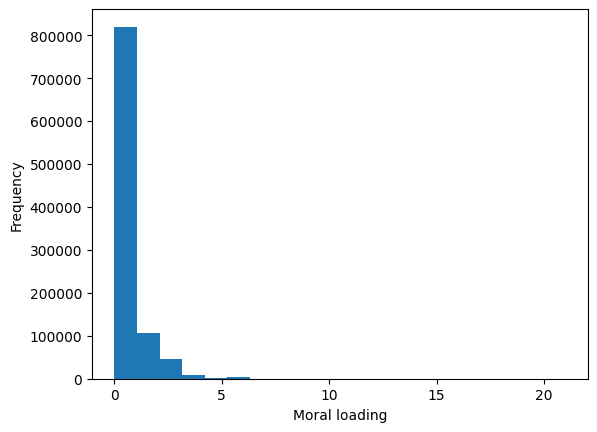

In [101]:
twitter_plots_data["moral_loading"].hist(bins=20, grid=False)
plt.xlabel("Moral loading")
plt.ylabel("Frequency")

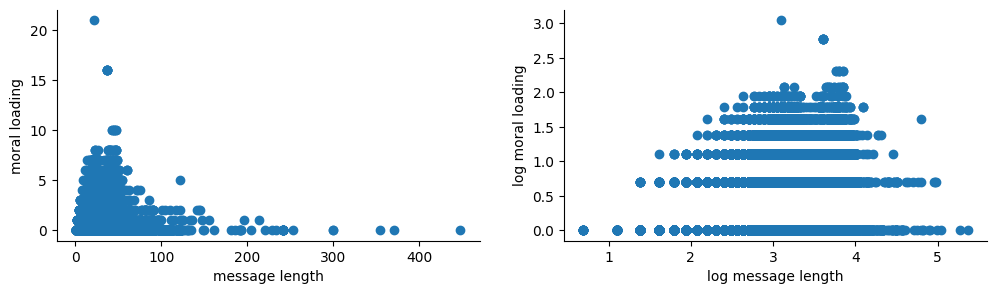

In [199]:
figsize = (12, 3)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = figsize)

ax[0].scatter(twitter_plots_data["message_len"], twitter_plots_data["moral_loading"])
ax[0].set_xlabel("message length")
ax[0].set_ylabel("moral loading")

ax[1].scatter(np.log(twitter_plots_data["message_len"]), np.log(twitter_plots_data["moral_loading"]))
ax[1].set_xlabel("log message length")
ax[1].set_ylabel("log moral loading")

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

In [ ]:
twitter_plots_data["moral_loading"].isnull()

count    986685.000000
mean          0.636215
std           0.965426
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          21.000000
Name: moral_loading, dtype: float64

In [15]:
def agg_log_plot(data, agg_col, mean_col, axes_labels):

  mask = (data[agg_col] > 0) & (data[mean_col] > 0)
  df = data[mask].copy()

  figsize = (8, 6)
  _, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

  grp = (
      df.groupby(agg_col, as_index=False)[mean_col]
        .apply(lambda s: np.log(s).mean())
        .rename(columns={mean_col: mean_col})
  )

  ax.scatter(np.log(grp[agg_col]), grp[mean_col])
  ax.set_xlabel(axes_labels[0])
  ax.set_ylabel(axes_labels[1])
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.legend()
  plt.tight_layout()


/var/folders/2h/91q4sd4x3t13f8n_dy5nkj_00000gn/T/ipykernel_1424/2691591929.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


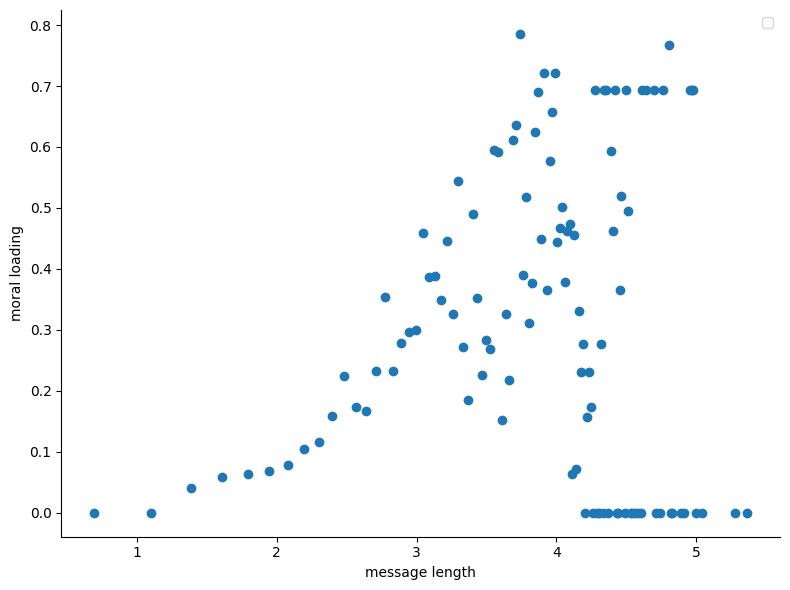

In [152]:
agg_log_plot(twitter_plots_data, "message_len", "moral_loading", ["message length", "moral loading"])

### Moral loading con word embeddings

In [31]:
twitter_plots_data["ddr_moral_loading"] = [cosine_similarity(moral_words_vector.reshape(1, -1), get_representation_vector(kv, doc).reshape(1, -1))[0, 0] for doc in docs_twitter]

Text(0, 0.5, 'Frequency')

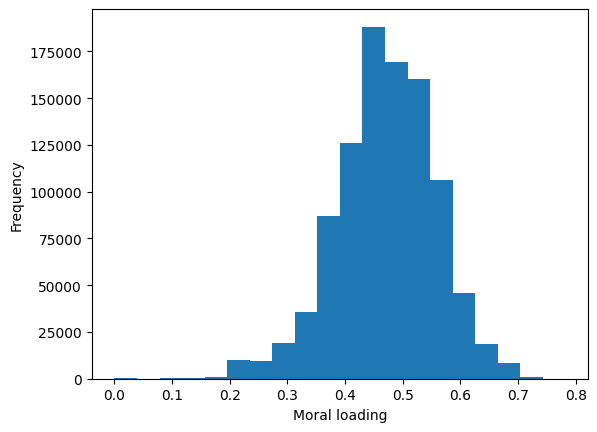

In [102]:
twitter_plots_data["ddr_moral_loading"].hist(bins=20, grid=False)
plt.xlabel("Moral loading")
plt.ylabel("Frequency")

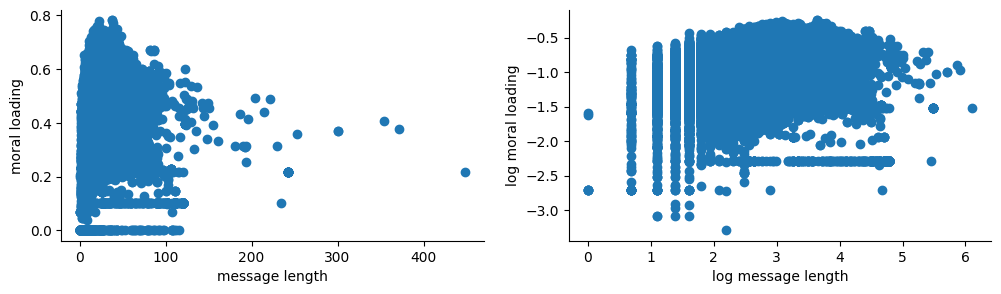

In [ ]:
figsize = (12, 3)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = figsize)

ax[0].scatter(twitter_plots_data["message_len"], twitter_plots_data["ddr_moral_loading"])
ax[0].set_xlabel("message length")
ax[0].set_ylabel("moral loading")

ax[1].scatter(np.log(twitter_plots_data["message_len"]), np.log(twitter_plots_data["ddr_moral_loading"]))
ax[1].set_xlabel("log message length")
ax[1].set_ylabel("log moral loading")

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

/var/folders/2h/91q4sd4x3t13f8n_dy5nkj_00000gn/T/ipykernel_1424/2691591929.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


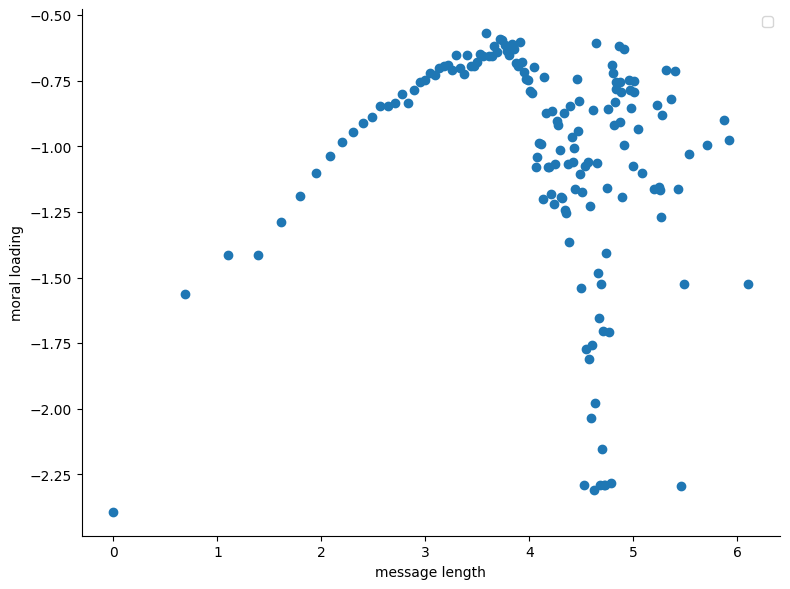

In [153]:
agg_log_plot(twitter_plots_data, "message_len", "ddr_moral_loading", ["message length", "moral loading"])

In [16]:
import numpy as np
from dataclasses import dataclass

@dataclass(frozen=True)
class PolyFitPredictor:
    """
    Predictor polinómico a partir de los outputs de _fit_line_with_ci.

    Todos los arrays internos (coef, grid, lo, hi) viven en el ESPACIO TRANSFORMADO,
    tal como los devolvió _fit_line_with_ci. Esta clase se encarga de:
      - Transformar x_new (log si aplica)
      - Evaluar el polinomio en x_new (np.polyval)
      - Volver al espacio original si corresponde (exp si log(y))
      - Interpolar IC sobre el grid (opcional), sin extrapolar por defecto

    Parámetros
    ----------
    coef : array-like
        Coeficientes del polinomio en espacio transformado (np.polyfit).
    grid : array-like
        Puntos de x (transformada) sobre los que se calculó fit/IC.
    lo, hi : array-like
        Límites inferior y superior del IC en el grid (transformados).
    apply_log_x, apply_log_y : bool
        Si se usó log en x e/y al ajustar.
    drop_nonpositive : {"drop", "shift"}
        - "drop": descarta x<=0 o y<=0 antes de log.
        - "shift": aplica log(x+eps) / log(y+eps).
    eps : float
        Pequeño desplazamiento usado con 'shift'.
    allow_ci_extrapolation : bool
        Si True, extrapola IC fuera de grid; si False, devuelve NaN para IC fuera de rango.
    """
    coef: np.ndarray
    grid: np.ndarray
    lo: np.ndarray
    hi: np.ndarray
    apply_log_x: bool = True
    apply_log_y: bool = True
    drop_nonpositive: str = "drop"
    eps: float = 1e-12
    allow_ci_extrapolation: bool = False

    # ---------- utilidades privadas ----------
    def _tx(self, x_new):
        x_new = np.asarray(x_new, dtype=float)
        if self.apply_log_x:
            if self.drop_nonpositive == "drop":
                return np.log(x_new)
            return np.log(x_new + self.eps)
        return x_new

    def _from_ty(self, y_t):
        if self.apply_log_y:
            return np.exp(y_t)
        return y_t

    def _interp_ci(self, x_t):
        if self.allow_ci_extrapolation:
            lo_t = np.interp(x_t, self.grid, self.lo, left=None, right=None)
            hi_t = np.interp(x_t, self.grid, self.hi, left=None, right=None)
        else:
            lo_t = np.full_like(x_t, np.nan, dtype=float)
            hi_t = np.full_like(x_t, np.nan, dtype=float)
            m = (x_t >= np.nanmin(self.grid)) & (x_t <= np.nanmax(self.grid))
            lo_t[m] = np.interp(x_t[m], self.grid, self.lo)
            hi_t[m] = np.interp(x_t[m], self.grid, self.hi)
        return lo_t, hi_t

    # ---------- API pública ----------
    def predict(self, x_new, return_original_space=True):
        """
        Predice ŷ para x_new. Si return_original_space=True y el ajuste fue en log(y),
        vuelve al espacio original con exp.
        """
        x_t = self._tx(x_new)
        y_t = np.polyval(self.coef, x_t)
        return self._from_ty(y_t) if return_original_space else y_t

    def predict_ci(self, x_new, return_original_space=True):
        """
        Devuelve (lo, hi) para x_new por interpolación sobre el grid.
        Si allow_ci_extrapolation=False, fuera de rango se devuelve NaN.
        """
        x_t = self._tx(x_new)
        lo_t, hi_t = self._interp_ci(x_t)
        if return_original_space and self.apply_log_y:
            return np.exp(lo_t), np.exp(hi_t)
        return lo_t, hi_t

    def predict_with_ci(self, x_new, return_original_space=True):
        """
        Devuelve (ŷ, lo, hi) juntos.
        """
        y = self.predict(x_new, return_original_space=return_original_space)
        lo, hi = self.predict_ci(x_new, return_original_space=return_original_space)
        return y, lo, hi

    # ---------- constructores auxiliares ----------
    @classmethod
    def from_fit_outputs(cls, grid, fit, lo, hi, coef,
                         apply_log_x=True, apply_log_y=True,
                         drop_nonpositive="drop", eps=1e-12,
                         allow_ci_extrapolation=False):
        """
        Crea un predictor a partir de lo que devuelve _fit_line_with_ci.
        """
        return cls(
            coef=np.asarray(coef, dtype=float),
            grid=np.asarray(grid, dtype=float),
            lo=np.asarray(lo, dtype=float),
            hi=np.asarray(hi, dtype=float),
            apply_log_x=apply_log_x,
            apply_log_y=apply_log_y,
            drop_nonpositive=drop_nonpositive,
            eps=eps,
            allow_ci_extrapolation=allow_ci_extrapolation
        )

In [81]:
import warnings
from scipy.stats import gaussian_kde

# --- helper robusto: línea + banda para un subconjunto (usa bootstrap) ---
def _fit_line_with_ci(x, y, degree=1, ci=95, n_boot=1500, n_grid=200, rng=None):
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()

    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    uniq = np.unique(x)
    if uniq.size < 2:
        raise ValueError("El subconjunto no tiene variación en X.")
    if degree >= uniq.size:
        warnings.warn(f"degree={degree} ≥ nº de x únicos ({uniq.size}). Se reduce a {uniq.size-1}.")
        degree = int(uniq.size - 1)

    order = np.argsort(x)
    x, y = x[order], y[order]
    grid = np.linspace(x.min(), x.max(), n_grid)

    coef = np.polyfit(x, y, deg=degree)
    y_hat = np.polyval(coef, grid)

    if rng is None:
        rng = np.random.default_rng(None)

    boots = []
    max_tries = n_boot * 10
    tries = 0
    while len(boots) < n_boot and tries < max_tries:
        tries += 1
        idx = rng.integers(0, x.size, x.size)
        xu, yu = x[idx], y[idx]
        if np.unique(xu).size < degree + 1:
            continue
        try:
            c = np.polyfit(xu, yu, deg=degree)
            boots.append(np.polyval(c, grid))
        except Exception:
            continue
    if not boots:
        raise RuntimeError("No se pudo construir el bootstrap para este rango.")

    boots = np.stack(boots, axis=0)
    lo_q = (100 - ci) / 2
    hi_q = 100 - lo_q
    lo, hi = np.percentile(boots, [lo_q, hi_q], axis=0)
    return grid, y_hat, lo, hi, coef

def plot_line_with_ci_multi(
    df, x_col, y_col, filter_col, ranges,
    axis_labels,
    degree=1, ci=95, n_boot=1500, n_grid=200,
    apply_log_x=True,
    apply_log_y=True, 
    drop_nonpositive="drop",
    random_state=None,
    plot_residuals = False
):
    """
    ranges: lista de tuplas [(a1,b1), (a2,b2), ...] sobre 'filter_col'
    drop_nonpositive: 'drop' elimina x<=0 o y<=0 antes del log; 'shift' suma eps.
    show_mean: si True, grafica el promedio de y por cada x (en el espacio transformado).
    mean_kwargs: dict opcional con estilo para el promedio (ej: {'marker':'o','linestyle':'-'}).
    """

    rng = np.random.default_rng(random_state)
    figsize = (12, 3) if plot_residuals else (12, 6)

    ncols = 2 if plot_residuals else 1
    fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize = figsize)
    eps = 1e-12
    
    colors = ['blue', 'red']
    i = 0
    residuals = np.array([])
    for (a, b) in ranges:
        sub = df[(df[filter_col] >= a) & (df[filter_col] <= b)].copy()
        if sub.empty:
            warnings.warn(f"Rango [{a}, {b}] vacío; se omite.")
            continue

        # extrae arrays originales
        x = sub[x_col].to_numpy(dtype=float)
        y = sub[y_col].to_numpy(dtype=float)

        # manejo de log en x
        if apply_log_x:
            if drop_nonpositive == "drop":
                m = x > 0
                x, y = x[m], y[m]
            x = np.log(x if drop_nonpositive == "drop" else x + eps)

        # manejo de log en y
        if apply_log_y:
            if drop_nonpositive == "drop":
                m = y > 0
                x, y = x[m], y[m]
            y = np.log(y if drop_nonpositive == "drop" else y + eps)

        tmp = pd.DataFrame({"x": x, "y": y})
        # promedio de y para cada valor único de x
        g = tmp.groupby("x", as_index=False, sort=True)["y"].mean()

        if plot_residuals:
            ax[0].scatter(g["x"].to_numpy(), g["y"].to_numpy(),
                    label=f"Mean log-log [{a}, {b}]", color = colors[i])
        else:
            ax.scatter(g["x"].to_numpy(), g["y"].to_numpy(),
                    label=f"Mean log-log [{a}, {b}]", color = colors[i])

        # Si quieres volver a activar el ajuste con IC, descomenta estas líneas y define _fit_line_with_ci
        grid, fit, lo, hi, coef = _fit_line_with_ci(
             x, y, degree=degree, ci=ci, n_boot=n_boot, n_grid=n_grid, rng=rng
        )

        pred = PolyFitPredictor.from_fit_outputs(
        grid, fit, lo, hi, coef,
        apply_log_x=apply_log_x,
        apply_log_y=apply_log_y,
        drop_nonpositive=drop_nonpositive,
        allow_ci_extrapolation=False  # pon True si quieres extrapolar IC (no recomendado)
        )

        #x_new = df[df[y_col]>0][x_col].to_numpy()
        #y_hat = pred.predict(np.log(x_new), return_original_space=True)
        #residuals = np.concatenate((y_hat - np.log(df[df[y_col]>0][y_col].to_numpy()), residuals), axis = 0)

        x_new = g["x"].to_numpy()
        y_hat = pred.predict(x_new, return_original_space=True)
        residuals = np.concatenate((y_hat - g["y"].to_numpy(), residuals), axis = 0)
        
        if plot_residuals:
            ax[0].plot(grid, fit, linewidth=2, label=f"Polyfit degree {degree} for [{a}, {b}]", color = colors[i])
            ax[0].fill_between(grid, lo, hi, alpha=0.18, label=f"IC {ci}% [{a:}, {b}]", color = colors[i])
        else:
            ax.plot(grid, fit, linewidth=2, label=f"Polyfit degree {degree} for [{a}, {b}]", color = colors[i])
            ax.fill_between(grid, lo, hi, alpha=0.18, label=f"IC {ci}% [{a:}, {b}]", color = colors[i])
        i+=1
    
    if plot_residuals:
        ax[0].set_xlabel(axis_labels[0])
        ax[0].set_ylabel(axis_labels[1])
        ax[0].legend(ncols=2, fontsize=9)
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False)

        ax[1].hist(residuals, 10, density = True, 
            histtype ='bar')
        ax[1].set_xlim(left = -5, right = 5)
        ax[1].set_xlabel("Residuals")
        ax[1].set_ylabel("Frequency")
    else:
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])
        ax.legend(ncols=2, fontsize=9)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)


    fig.tight_layout()
    return ax



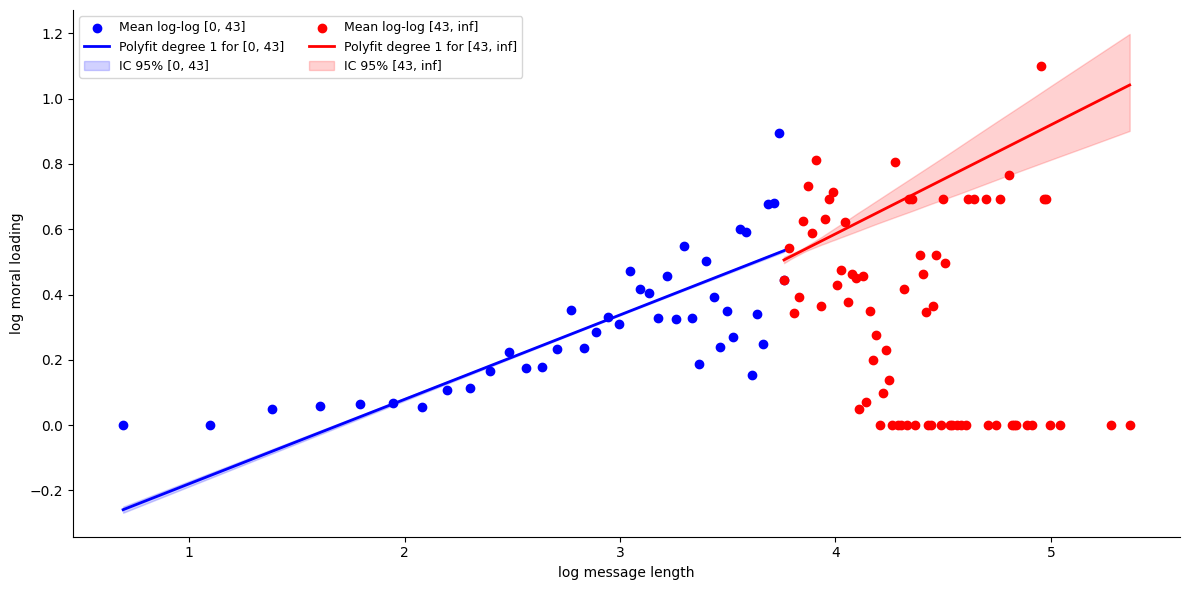

In [82]:
ranges = [(0, 43), (43, np.inf)]  # pon los que quieras

plot_line_with_ci_multi(
    twitter_plots_data,
    x_col="message_len",
    y_col="moral_loading",
    filter_col="message_len",
    ranges=ranges,
    axis_labels=["log message length", "log moral loading"],
    degree=1,
    ci=95,
    n_boot=1500,
    n_grid=200,
    apply_log_x=True,
    apply_log_y=True,
    random_state=42
)
plt.show()

/var/folders/2h/91q4sd4x3t13f8n_dy5nkj_00000gn/T/ipykernel_3359/2539204230.py:49: RuntimeWarning: divide by zero encountered in log
  return np.log(x_new)
/opt/miniconda3/envs/capstone-project/lib/python3.11/site-packages/numpy/lib/_polynomial_impl.py:787: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


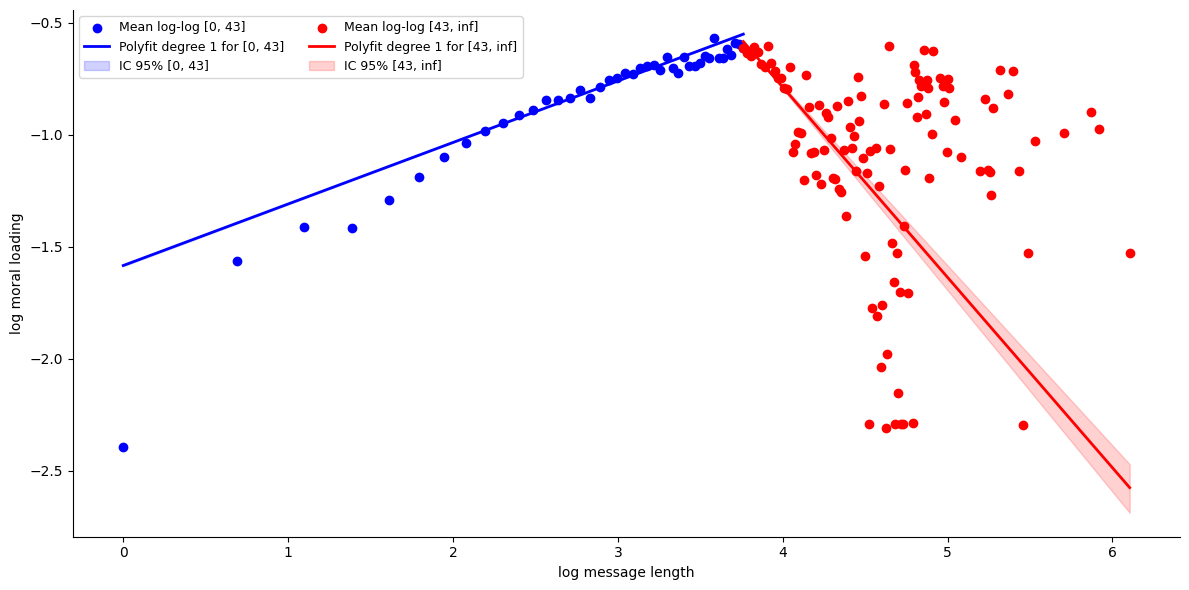

In [83]:
ranges = [(0, 43), (43, np.inf)]  # pon los que quieras

plot_line_with_ci_multi(
    twitter_plots_data,
    x_col="message_len",
    y_col="ddr_moral_loading",
    filter_col="message_len",
    ranges=ranges,
    axis_labels=["log message length", "log moral loading"],
    degree=1,
    ci=95,
    n_boot=1500,
    n_grid=200,
    apply_log_x=True,
    apply_log_y=True,
    random_state=42
)
plt.show()

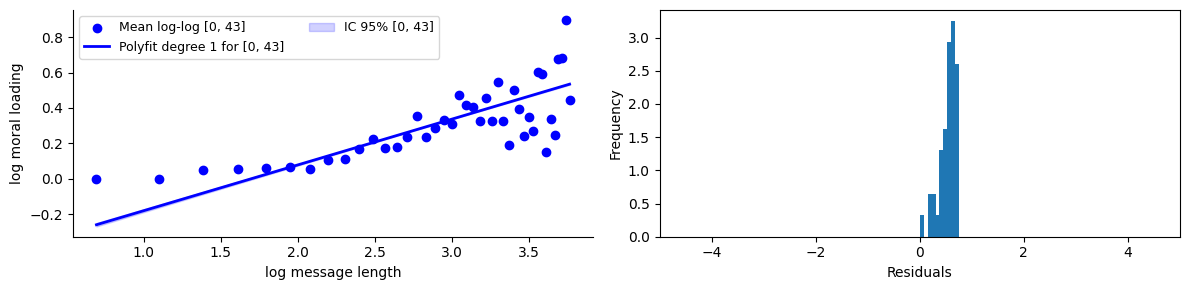

In [85]:
ranges = [(0, 43)]  # pon los que quieras

plot_line_with_ci_multi(
    twitter_plots_data,
    x_col="message_len",
    y_col="moral_loading",
    filter_col="message_len",
    ranges=ranges,
    axis_labels=["log message length", "log moral loading"],
    degree=1,
    ci=95,
    n_boot=1500,
    n_grid=200,
    apply_log_x=True,
    apply_log_y=True,
    random_state=42,
    plot_residuals=True
)
plt.show()

/var/folders/2h/91q4sd4x3t13f8n_dy5nkj_00000gn/T/ipykernel_3359/2539204230.py:49: RuntimeWarning: divide by zero encountered in log
  return np.log(x_new)
/opt/miniconda3/envs/capstone-project/lib/python3.11/site-packages/numpy/lib/_polynomial_impl.py:787: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


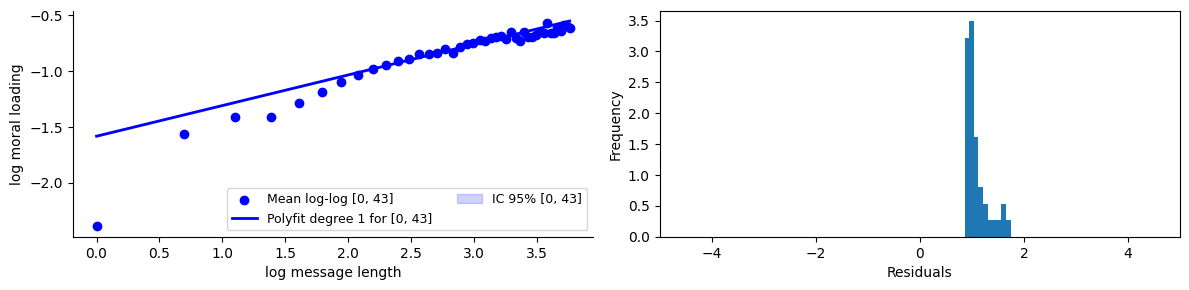

In [ ]:
ranges = [(0, 43)]  # pon los que quieras

plot_line_with_ci_multi(
    twitter_plots_data,
    x_col="message_len",
    y_col="ddr_moral_loading",
    filter_col="message_len",
    ranges=ranges,
    axis_labels=["log message length", "log moral loading"],
    degree=1,
    ci=95,
    n_boot=1500,
    n_grid=200,
    apply_log_x=True,
    apply_log_y=True,
    random_state=42,
    plot_residuals=True
)
plt.show()

/var/folders/2h/91q4sd4x3t13f8n_dy5nkj_00000gn/T/ipykernel_3359/2539204230.py:49: RuntimeWarning: divide by zero encountered in log
  return np.log(x_new)
/opt/miniconda3/envs/capstone-project/lib/python3.11/site-packages/numpy/lib/_polynomial_impl.py:787: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


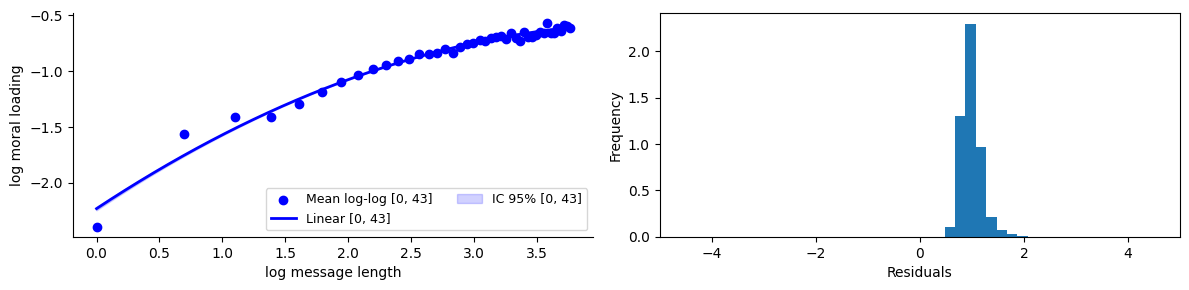

In [ ]:
ranges = [(0, 43)]  # pon los que quieras

plot_line_with_ci_multi(
    twitter_plots_data,
    x_col="message_len",
    y_col="ddr_moral_loading",
    filter_col="message_len",
    ranges=ranges,
    axis_labels=["log message length", "log moral loading"],
    degree=2,
    ci=95,
    n_boot=1500,
    n_grid=200,
    apply_log_x=True,
    apply_log_y=True,
    random_state=42,
    plot_residuals=True
)
plt.show()

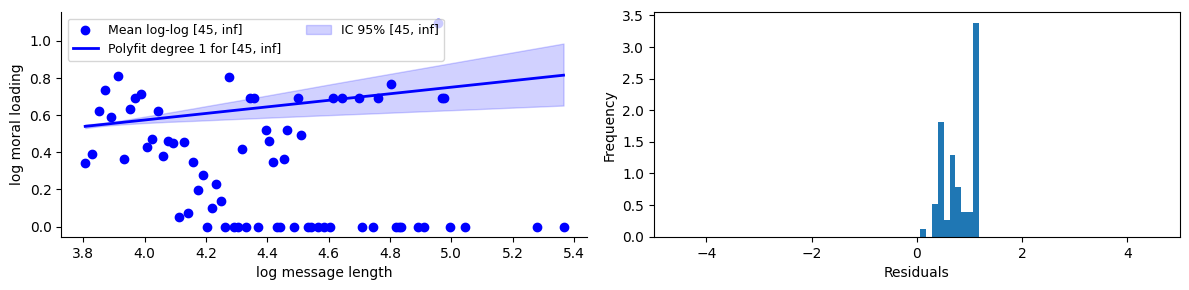

In [ ]:
ranges = [(45, np.inf)]  # pon los que quieras

plot_line_with_ci_multi(
    twitter_plots_data,
    x_col="message_len",
    y_col="moral_loading",
    filter_col="message_len",
    ranges=ranges,
    axis_labels=["log message length", "log moral loading"],
    degree=1,
    ci=95,
    n_boot=1500,
    n_grid=200,
    apply_log_x=True,
    apply_log_y=True,
    random_state=42,
    plot_residuals=True
)
plt.show()


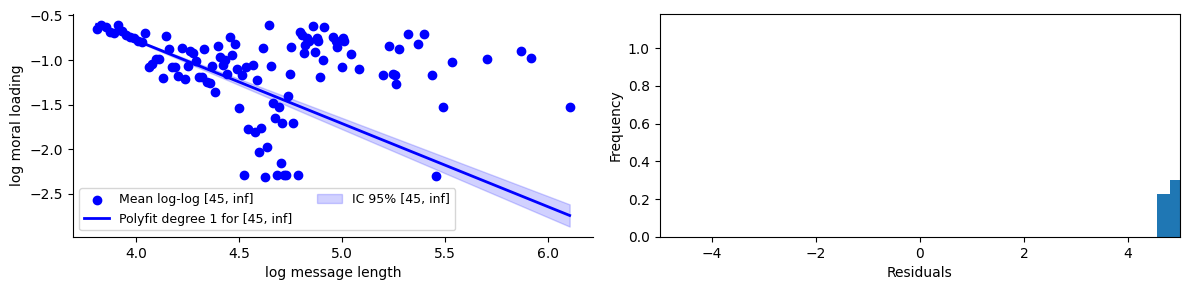

In [ ]:
ranges = [(45, np.inf)]  # pon los que quieras

plot_line_with_ci_multi(
    twitter_plots_data,
    x_col="message_len",
    y_col="ddr_moral_loading",
    filter_col="message_len",
    ranges=ranges,
    axis_labels=["log message length", "log moral loading"],
    degree=1,
    ci=95,
    n_boot=1500,
    n_grid=200,
    apply_log_x=True,
    apply_log_y=True,
    random_state=42,
    plot_residuals=True
)
plt.show()


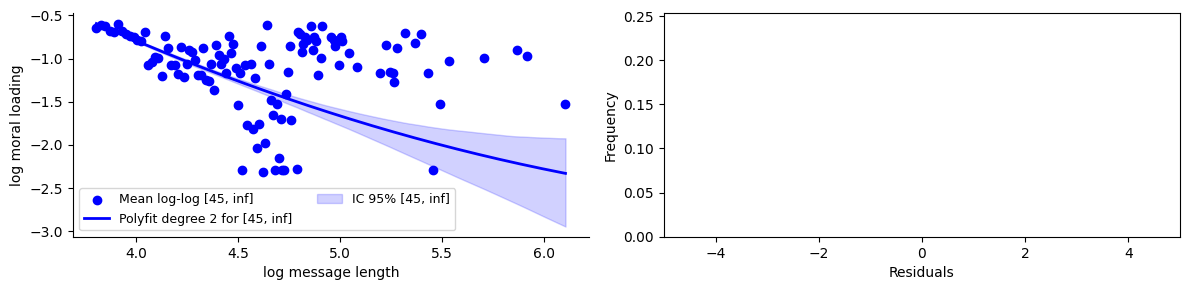

In [ ]:
ranges = [(45, np.inf)]  # pon los que quieras

plot_line_with_ci_multi(
    twitter_plots_data,
    x_col="message_len",
    y_col="ddr_moral_loading",
    filter_col="message_len",
    ranges=ranges,
    axis_labels=["log message length", "log moral loading"],
    degree=2,
    ci=95,
    n_boot=1500,
    n_grid=200,
    apply_log_x=True,
    apply_log_y=True,
    random_state=42,
    plot_residuals=True
)
plt.show()

## Análisis Reddit

In [63]:
data_reddit = pd.read_csv("Data/Reddit/Threads_corpus_ALL_Reddit.csv")
data_reddit.drop("Unnamed: 0", axis=1, inplace=True)
data_reddit.head(5)

,created_utc,author_fullname,title,selftext,full_link,total_n_replies,channel,id,is_video,is_original_content,score,media_only,title_thread
0,1590708669,t2_2iyufn,Trump signs social media executive order to re...,NaN,https://www.reddit.com/r/The_Donald/comments/g...,2950,The_Donald,gshffi,False,False,1,False,Trump signs social media executive order to re...
1,1584500691,t2_2iyufn,Veterans Needing Assistance Getting Remote Hea...,If you need help getting setup with the VHA vi...,https://www.reddit.com/r/The_Donald/comments/f...,2,The_Donald,fkille,False,False,1,False,Veterans Needing Assistance Getting Remote Hea...
2,1584397773,t2_qt1ca,President Trump's Coronavirus Guidelines for A...,**15 days to slow the spread** ------ - Listen...,https://www.reddit.com/r/The_Donald/comments/f...,2,The_Donald,fjttfh,False,False,70,False,President Trump's Coronavirus Guidelines for A...
3,1584316486,t2_lea1s1i,WATCH PARTY: Dem(entia) Debate Disaster - Comm...,"#[Welcome back, Centipedes. It’s time for anot...",https://www.reddit.com/r/The_Donald/comments/f...,2,The_Donald,fjb8qw,False,False,1,False,WATCH PARTY: Dem(entia) Debate Disaster - Comm...
4,1584306846,t2_2iyufn,Members of the Coronavirus Task Force Hold a P...,NaN,https://www.reddit.com/r/The_Donald/comments/f...,2,The_Donald,fj8ph7,False,False,1,False,Members of the Coronavirus Task Force Hold a P...


In [64]:
data_reddit.columns

Index(['created_utc', 'author_fullname', 'title', 'selftext', 'full_link',
       'total_n_replies', 'channel', 'id', 'is_video', 'is_original_content',
       'score', 'media_only', 'title_thread'],
      dtype='object')

In [65]:
data_reddit["title"].head(5).values[1]

'Veterans Needing Assistance Getting Remote Healthcare'

In [66]:
data_reddit["selftext"].head(5).values[1]

"If you need help getting setup with the VHA via telehealth or MyHealtheVet messaging, feel free to DM me and I will assist you setting up a user, teach you how to use the site or app, and get you connected to your docs so you don't have to go into a facility unless 100% necessary. There is absolutely no need for Veterans to go into VHA facilities right now for anything that can be done remotely, including refilling prescriptions, seeing a doctor for a non-emergency, having a Behavioral Health clinic appointment, etc.. They are starting to screen people and limit access at many VHA Hospitals and Clinics. So, message me and let's get you set so we can keep you healthy. [Go here for comments and to contact me](https://thedonald.win/p/FMA99ZAn/veterans-needing-assistance-gett/)"

In [220]:
data_reddit["title_thread"].head(5).values[1]

"Veterans Needing Assistance Getting Remote Healthcare. If you need help getting setup with the VHA via telehealth or MyHealtheVet messaging, feel free to DM me and I will assist you setting up a user, teach you how to use the site or app, and get you connected to your docs so you don't have to go into a facility unless 100% necessary. There is absolutely no need for Veterans to go into VHA facilities right now for anything that can be done remotely, including refilling prescriptions, seeing a doctor for a non-emergency, having a Behavioral Health clinic appointment, etc.. They are starting to screen people and limit access at many VHA Hospitals and Clinics. So, message me and let's get you set so we can keep you healthy. [Go here for comments and to contact me](https://thedonald.win/p/FMA99ZAn/veterans-needing-assistance-gett/)"

In [222]:
data_reddit["full_link"].head(5).values[1]

'https://www.reddit.com/r/The_Donald/comments/fkille/veterans_needing_assistance_getting_remote/'

In [225]:
null_text = sum(data_reddit["selftext"].isnull())
total = len(data_reddit)

print(f'Número total con null selftext: {null_text}')
print(f'Número total de datos: {total}')

Número total con null selftext: 952367
Número total de datos: 1067832


In [228]:
data_reddit[data_reddit["title_thread"].str.contains("WHO CONTROLS THE PAST CONTROLS THE FUTURE")]

,created_utc,author_fullname,title,selftext,full_link,total_n_replies,channel,id,is_video,is_original_content,score,media_only,title_thread
9430,1582600016,t2_2xkmizis,WHO CONTROLS THE PAST CONTROLS THE FUTURE [Thi...,NaN,https://www.reddit.com/r/The_Donald/comments/f...,5,The_Donald,f93ini,False,False,1,False,WHO CONTROLS THE PAST CONTROLS THE FUTURE [Thi...


In [230]:
data_reddit[data_reddit["title_thread"].str.contains("Sen Rand Paul - I know this")]

,created_utc,author_fullname,title,selftext,full_link,total_n_replies,channel,id,is_video,is_original_content,score,media_only,title_thread
648990,1570639382,t2_3u6za,"Sen Rand Paul - I know this, Donald Trump is t...",NaN,https://www.reddit.com/r/The_Donald/comments/d...,135,The_Donald,dfjp34,False,False,2950,False,"Sen Rand Paul - I know this, Donald Trump is t..."


In [68]:
docs_reddit = data_reddit["title"].astype(str).values

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs_reddit)):
    docs_reddit[idx] = docs_reddit[idx].upper()  # Convert to lowercase.
    docs_reddit[idx] = tokenizer.tokenize(docs_reddit[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs_reddit = [[token for token in doc if not token.isnumeric()] for doc in docs_reddit]

# Remove words that are only one character.
docs_reddit = [[token for token in doc if len(token) > 1] for doc in docs_reddit]

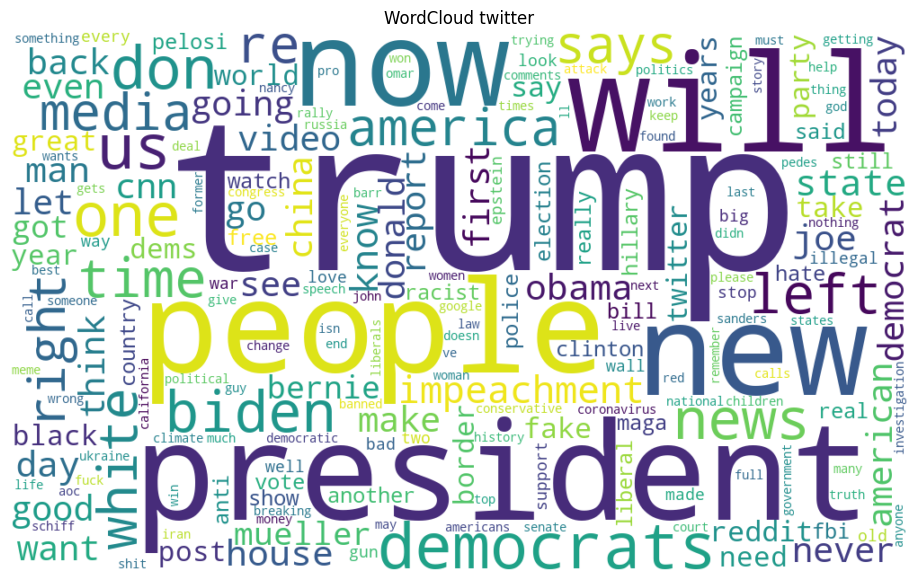

In [92]:
min_len = 2                # longitud mínima de token
solo_alfabetico = True     # descartar tokens con números/símbolos
extra_stopwords = {
    # añade las tuyas; ejemplo en español:
    "https", "http", "rt", "via", "q", "amp"
}
stopwords = set(STOPWORDS) | extra_stopwords

# --- Aplanar y filtrar ---
tokens = [tok for tw in docs_reddit for tok in tw]
if solo_alfabetico:
    tokens = [t for t in tokens if t.isalpha()]
tokens = [t.lower() for t in tokens if len(t) >= min_len and t.lower() not in stopwords]

freqs = Counter(tokens)  # {'hola': 3, 'mundo': 2, ...}

wc_freq = WordCloud(
    width=1000, height=600,
    background_color="white"
).generate_from_frequencies(freqs)

plt.figure(figsize=(12,7))
plt.imshow(wc_freq, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud twitter")
plt.show()

In [69]:
docs_reddit[0]

['TRUMP',
 'SIGNS',
 'SOCIAL',
 'MEDIA',
 'EXECUTIVE',
 'ORDER',
 'TO',
 'REVOKE',
 'LIABILITY',
 'PROTECTIONS',
 'FROM',
 'BIAS',
 'SOCIAL',
 'MEDIA',
 'PUBLISHERS']

In [70]:
data_reddit["message_len"] = [len(doc) for doc in docs_reddit]
data_reddit["moral_loading"] = [moral_counter(doc, moral_words) for doc in docs_reddit]
data_reddit["moral_ratio"] = data_reddit["moral_loading"] / data_reddit["message_len"]

In [93]:
reddit_plots_data = data_reddit.copy()

### Gráficos básicos

Text(0, 0.5, 'Frequency')

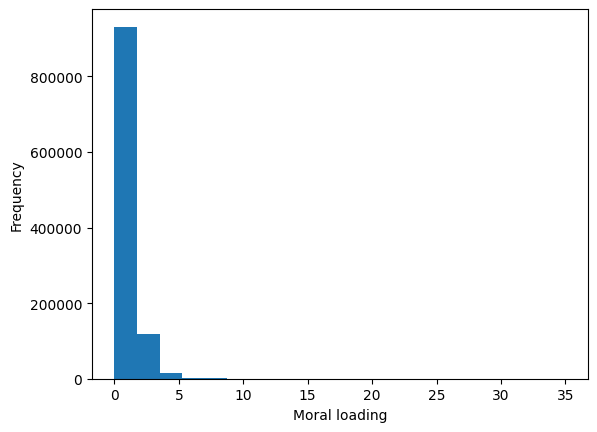

In [100]:
reddit_plots_data["moral_loading"].hist(bins=20, grid=False)
plt.xlabel("Moral loading")
plt.ylabel("Frequency")

/opt/miniconda3/envs/capstone-project/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


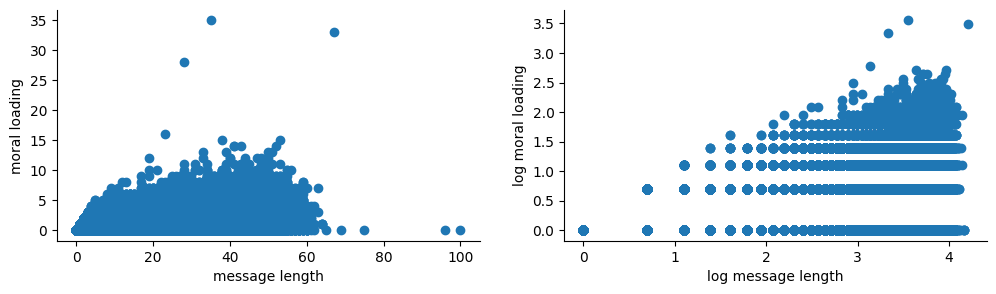

In [235]:
figsize = (12, 3)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = figsize)

ax[0].scatter(reddit_plots_data["message_len"], reddit_plots_data["moral_loading"])
ax[0].set_xlabel("message length")
ax[0].set_ylabel("moral loading")

ax[1].scatter(np.log(reddit_plots_data["message_len"]), np.log(reddit_plots_data["moral_loading"]))
ax[1].set_xlabel("log message length")
ax[1].set_ylabel("log moral loading")

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

/var/folders/2h/91q4sd4x3t13f8n_dy5nkj_00000gn/T/ipykernel_1424/2691591929.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


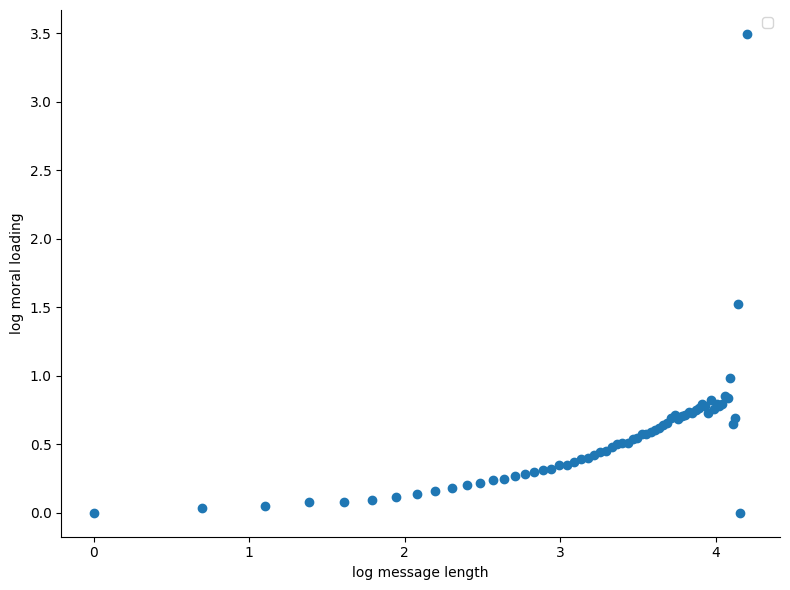

In [244]:
agg_log_plot(reddit_plots_data, "message_len", "moral_loading", ["log message length", "log moral loading"])

### Incorporar word embedding

In [104]:
reddit_plots_data["ddr_moral_loading"] = [cosine_similarity(moral_words_vector.reshape(1, -1), get_representation_vector(kv, doc).reshape(1, -1))[0, 0] for doc in docs_reddit]

Text(0, 0.5, 'Frequency')

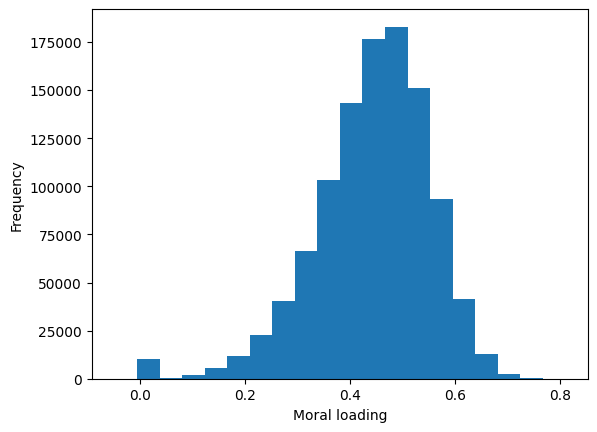

In [105]:
reddit_plots_data["ddr_moral_loading"].hist(bins=20, grid=False)
plt.xlabel("Moral loading")
plt.ylabel("Frequency")

/var/folders/2h/91q4sd4x3t13f8n_dy5nkj_00000gn/T/ipykernel_1424/2691591929.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


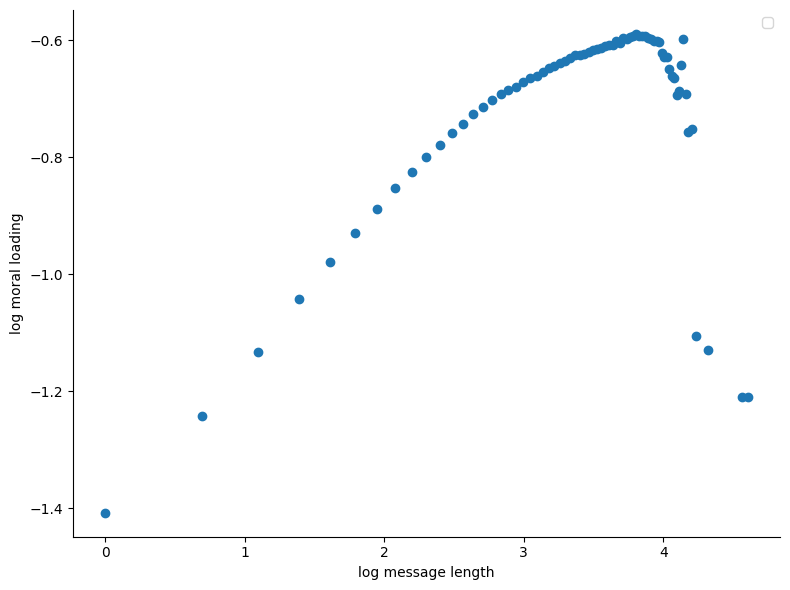

In [241]:
agg_log_plot(reddit_plots_data, "message_len", "ddr_moral_loading", ["log message length", "log moral loading"])

/var/folders/2h/91q4sd4x3t13f8n_dy5nkj_00000gn/T/ipykernel_3359/2539204230.py:49: RuntimeWarning: divide by zero encountered in log
  return np.log(x_new)
/opt/miniconda3/envs/capstone-project/lib/python3.11/site-packages/numpy/lib/_polynomial_impl.py:787: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


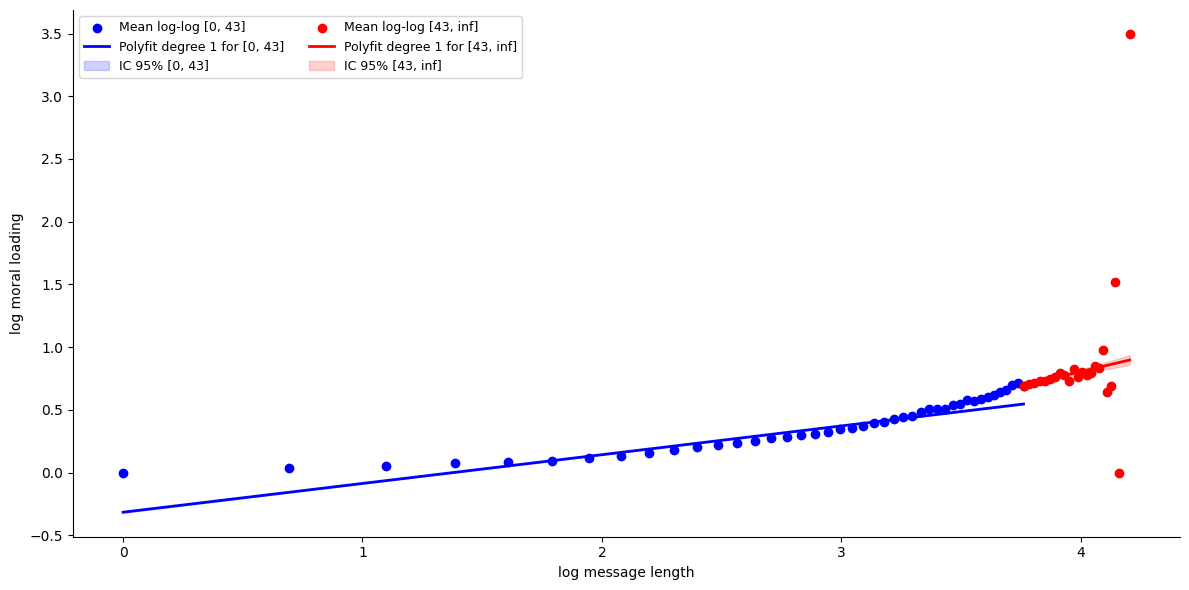

In [ ]:
ranges = [(0, 43), (43, np.inf)]  # pon los que quieras

plot_line_with_ci_multi(
    reddit_plots_data,
    x_col="message_len",
    y_col="moral_loading",
    filter_col="message_len",
    ranges=ranges,
    axis_labels=["log message length", "log moral loading"],
    degree=1,
    ci=95,
    n_boot=1500,
    n_grid=200,
    apply_log_x=True,
    apply_log_y=True,
    random_state=42
)
plt.show()

/var/folders/2h/91q4sd4x3t13f8n_dy5nkj_00000gn/T/ipykernel_3359/2539204230.py:49: RuntimeWarning: divide by zero encountered in log
  return np.log(x_new)
/opt/miniconda3/envs/capstone-project/lib/python3.11/site-packages/numpy/lib/_polynomial_impl.py:787: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


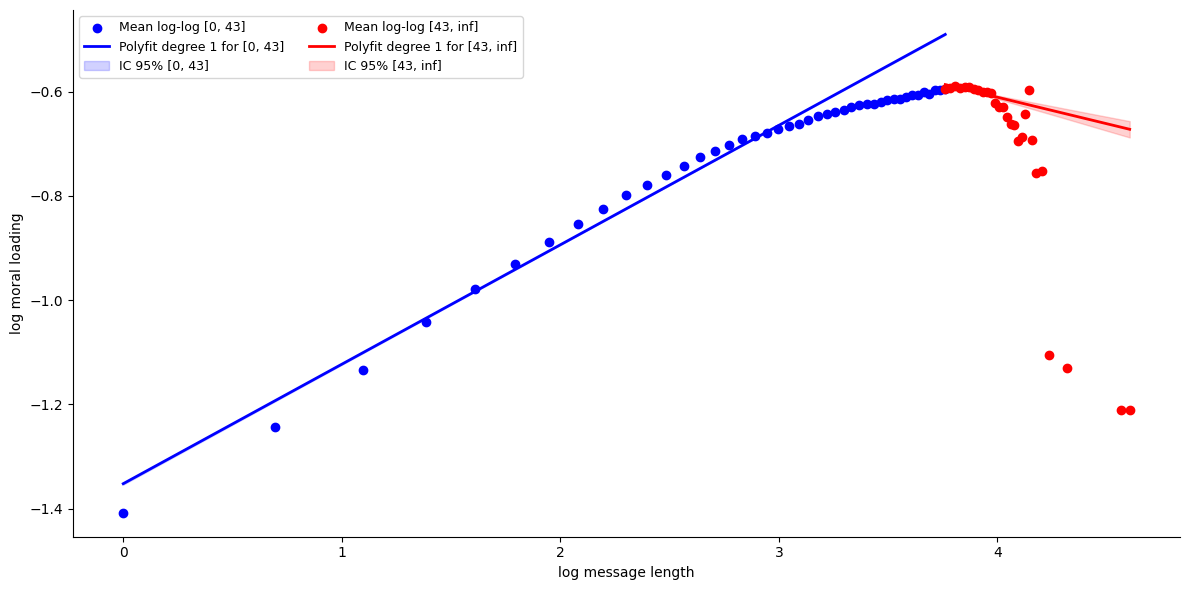

In [87]:
ranges = [(0, 43), (43, np.inf)]  # pon los que quieras

plot_line_with_ci_multi(
    reddit_plots_data,
    x_col="message_len",
    y_col="ddr_moral_loading",
    filter_col="message_len",
    ranges=ranges,
    axis_labels=["log message length", "log moral loading"],
    degree=1,
    ci=95,
    n_boot=1500,
    n_grid=200,
    apply_log_x=True,
    apply_log_y=True,
    random_state=42
)
plt.show()

/var/folders/2h/91q4sd4x3t13f8n_dy5nkj_00000gn/T/ipykernel_3359/2539204230.py:49: RuntimeWarning: divide by zero encountered in log
  return np.log(x_new)
/opt/miniconda3/envs/capstone-project/lib/python3.11/site-packages/numpy/lib/_polynomial_impl.py:787: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


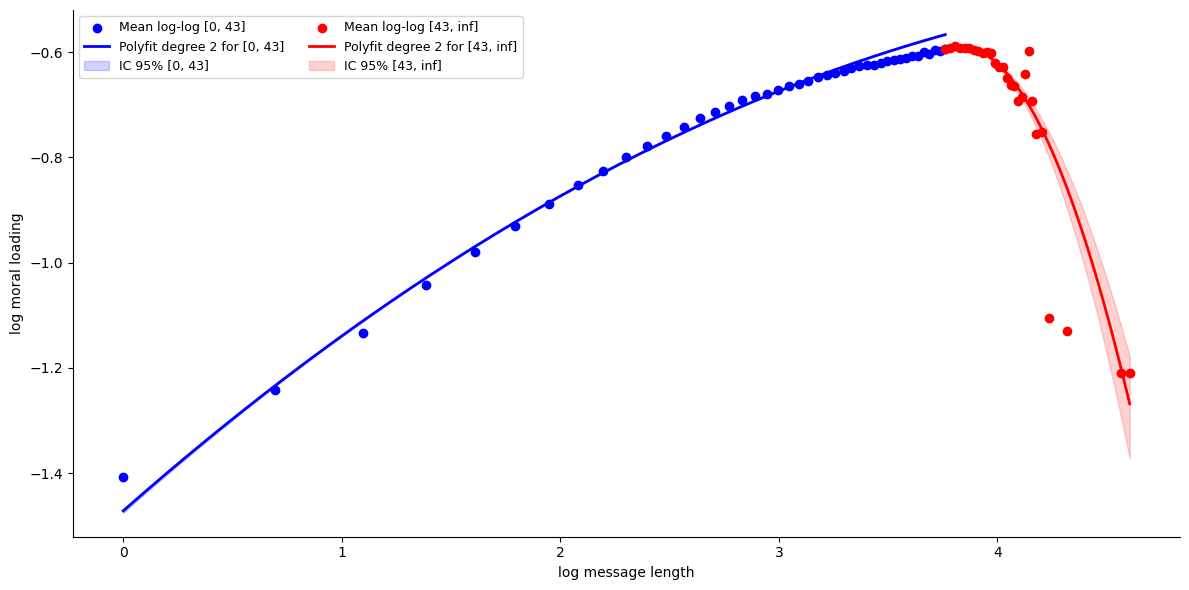

In [88]:
ranges = [(0, 43), (43, np.inf)]  # pon los que quieras

plot_line_with_ci_multi(
    reddit_plots_data,
    x_col="message_len",
    y_col="ddr_moral_loading",
    filter_col="message_len",
    ranges=ranges,
    axis_labels=["log message length", "log moral loading"],
    degree=2,
    ci=95,
    n_boot=1500,
    n_grid=200,
    apply_log_x=True,
    apply_log_y=True,
    random_state=42
)
plt.show()